# Unsupervised exploration of Iris dataset

In [6]:
import numpy as np
import scipy as sp
import pystan
import arviz
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t
import csv
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
%matplotlib inline

## Problem

Model the Iris-flower data set. Each data point is a vector of 4 features: (0,1,2,3). We assume that there are 3 components in the data: (0,1,2).

## Data

Load the iris data:

In [7]:
iris = load_iris()
data = np.array(iris['data']);
labels = np.array(iris['target']);

Prepare a zero-mean dataset:

In [8]:
data = data - np.mean(data, axis=0)
data_and_labels = np.column_stack((data, labels))  #np.concatenate((data, labels), axis=1)

#print(data[:,3])
#print(data.shape)  # (150,4)
#print(labels.shape)  # (150,)
#print(data_and_labels.shape)  # (150,5)

## Data exploration:

Histograms of each feature:

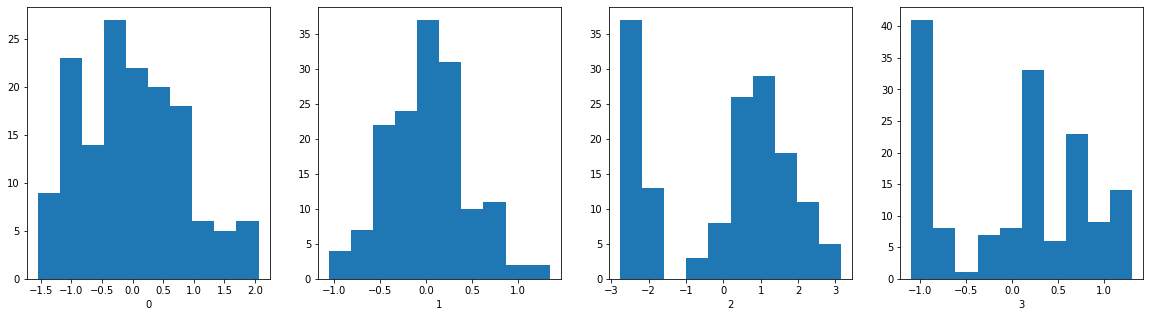

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#for d in data:
for ftr in range(data.shape[1]):
    ax[ftr].hist(data[:,ftr].astype(np.float))
    ax[ftr].set_xlabel(ftr)

plt.show()

Assessment of the informativeness of the features: for each of the 4 features, we plot the feature data per label (which is supposed to be unknown).

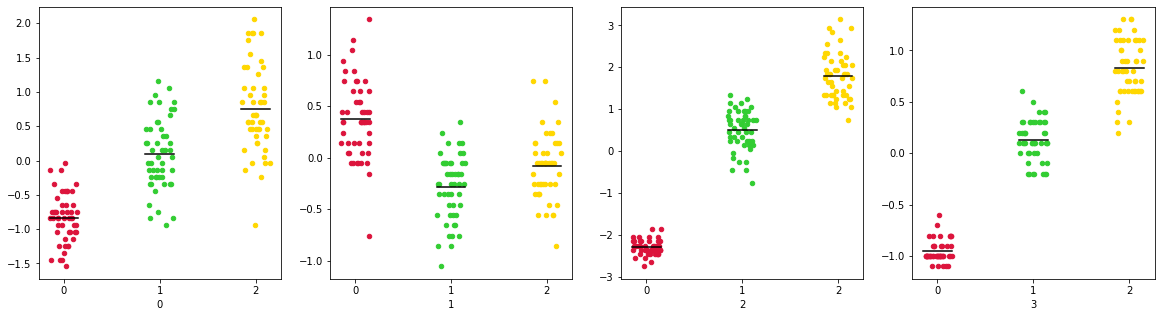

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#data = np.random.rayleigh(scale=1, size=(30,4))
labels_num = ['0','1','2']
colors = ['crimson', 'limegreen', 'gold']

width=0.3
#fig, ax = plt.subplots()

#for d in data:
for ftr in range(data.shape[1]):
    for i, lbl in enumerate(labels_num):
        data_lbl = data_and_labels[data_and_labels[:,4] == float(lbl)]
        data_lbl = data_lbl[:,ftr]
        x = np.ones(data_lbl.shape[0])*i + (np.random.rand(data_lbl.shape[0])*width-width/2.)
        ax[ftr].scatter(x, data_lbl, color=colors[i], s=20)
        mean = data_lbl.mean()
        ax[ftr].plot([i-width/2., i+width/2.],[mean,mean], color="k")

    ax[ftr].set_xticks(range(len(labels_num)))
    ax[ftr].set_xticklabels(labels_num)
    ax[ftr].set_xlabel(ftr)

plt.show()

## Model

We use GMM to model the Iris dataset. We first project the 4-dimensional data into a 1-dimentional subspace, and model the projected data as GMM with 3 components.<br>

We first run PCA on the dataset of shape (150,4), and take the first component of it (largest data variation), which is of shape (4,1).
We model the original 4-d observations as a linear combination of 4 coefficients, while using the pca component as a prior over these coefficients.<br>

It is known that the Iris dataset contains exactly 50 records per component, hence we are using '1/3' as the probability for each data point y_i to be associated with each of the components.

In [11]:
pca = PCA(n_components=1)
pca.fit(data)
pca_comp = pca.components_[0]
data_for_model = {'N':len(data), 'y': data, 'beta_priors': pca_comp}

print("pca 1st component: ", pca_comp)

pca 1st component:  [ 0.36138659 -0.08452251  0.85667061  0.3582892 ]


In [12]:
K = 3;
N = len(data);
D = 4;

In [13]:
model_1 = """
data {
 int<lower = 0> N;
 real y[N,4];
 real beta_priors[4];
}

parameters {
  ordered[3] mu;
  real<lower=0> sigma[3];
  real beta[5];
}
  
model {
 real comp[3];
 real y_tild[N];
 
 mu ~ normal(0, 10);
 sigma ~ lognormal(0, 10);
 
 beta[1] ~ normal(0,0.03);
 for (i in 2:5){
     beta[i] ~ normal(beta_priors[i-1], 0.03);
 }
 
 
 for (n in 1:N){
     y_tild[n] = beta[1] + beta[2]*y[n,1] + beta[3]*y[n,2] + beta[4]*y[n,3] + beta[5]*y[n,4];
     for (k in 1:3){
         comp[k] = normal_lpdf(y_tild[n] | mu[k], sigma[k]);
    }
    target += log_sum_exp(comp);
 }
}
"""

In [14]:
model_2 = """
data {
 int<lower = 0> N;
 real y[N,4];
 real beta_priors[4];
}

parameters {
  ordered[3] mu;
  real<lower=0> sigma[3];
  real beta[5];
  real<lower=0> tau;
}
  
model {
 real comp[3];
 real y_tild[N];
 
 tau ~ normal(0, 10);
 mu ~ student_t(2, 0, tau);
 sigma ~ student_t(2, 0, 10);
 
 beta[1] ~ normal(0,0.03);
 for (i in 2:5){
     beta[i] ~ normal(beta_priors[i-1], 0.03);
 }
 
 
 for (n in 1:N){
     y_tild[n] = beta[1] + beta[2]*y[n,1] + beta[3]*y[n,2] + beta[4]*y[n,3] + beta[5]*y[n,4];
     for (k in 1:3){
         comp[k] = normal_lpdf(y_tild[n] | mu[k], sigma[k]);
    }
    target += log_sum_exp(comp);
 }
}
"""

Load the model:

In [15]:
model_1 = pystan.StanModel(model_code=model_1)
model_2 = pystan.StanModel(model_code=model_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c54337a741dcc5593be332c25541f49d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_593fdd5f42b8957db8d91beb270000b4 NOW.


## Inference and Analyse

Collect samples from the posterior:

In [ ]:
print("MODEL 1:")
iterations = 1000
fit_1 = model_1.sampling(data=data_for_model, iter=iterations, chains=4, init=lambda: {'mu': [-2, 0, 2], 'sigma': [1, 1, 1], 'beta':[1,1,1,1,1]})
print(fit_1)
_ = arviz.plot_trace(fit_1)

MODEL 1:


MODEL 2:
Inference for Stan model: anon_model_593fdd5f42b8957db8d91beb270000b4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
mu[1]      -2.22  3.3e-3    0.1  -2.41  -2.29   -2.22  -2.15  -2.03    886    1.0
mu[2]       0.77  7.6e-3   0.21    0.4    0.6    0.77   0.94   1.15    750    1.0
mu[3]       1.43  7.6e-3   0.23   1.02   1.26    1.43    1.6   1.86    888    1.0
sigma[1]    0.17  5.2e-4   0.02   0.14   0.16    0.17   0.19   0.22   1593    1.0
sigma[2]    0.71  5.2e-3   0.15   0.47    0.6    0.69   0.79   1.07    834    1.0
sigma[3]     0.8  4.7e-3   0.15   0.55   0.69    0.79    0.9   1.13   1036    1.0
beta[1]  -7.2e-4  7.3e-4   0.03  -0.06  -0.02 -1.2e-3   0.02   0.06   1797    1.0
beta[2]     0.25  7.6e-4   0.03   0.19   0.23    0.25   0.27   0.31   1504    1.0
beta[3]    -0.13  6.3e-4   0.03  -0.18  -0.15   -0.13  -0.11  -0.0

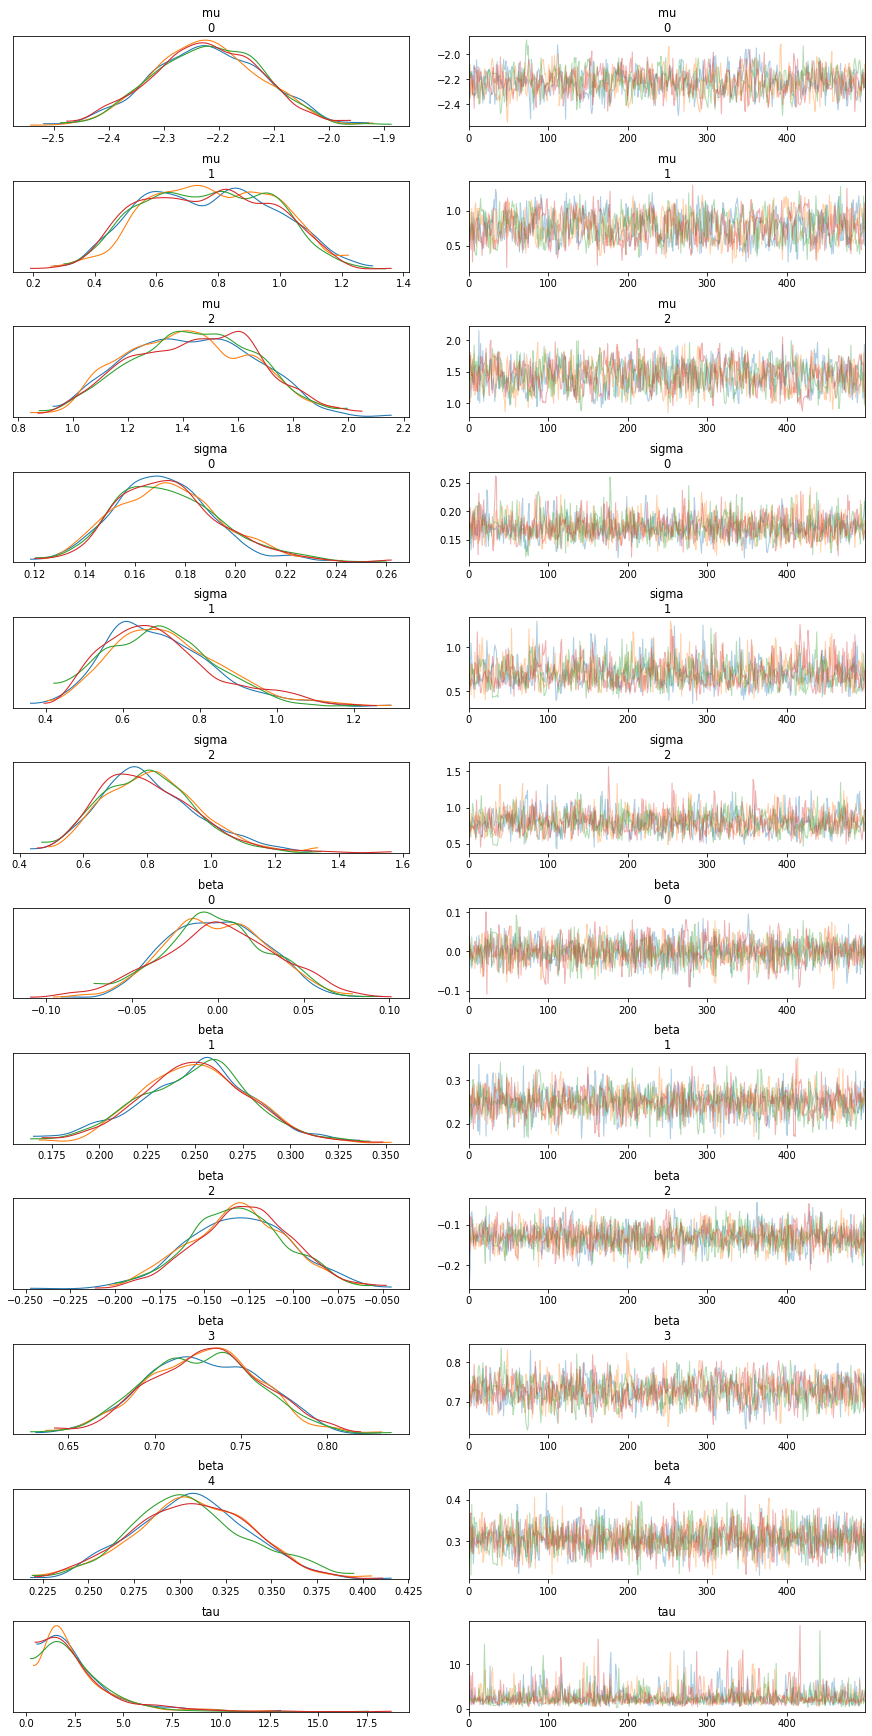

In [12]:
print("MODEL 2:")
iterations = 1000
fit_2 = model_2.sampling(data=data_for_model, iter=iterations, chains=4, init=lambda: {'mu': [-2, 0, 2], 'sigma': [1, 1, 1], 'beta':[1,1,1,1,1], 'tau':1})
print(fit_2)
_ = arviz.plot_trace(fit_2)

Here we sample from the posterior distribution and show two plots:<br>
1). The ground-truth labels overlaid with the estimated Gaussian functions.<br>
2). The estimated labels (hard assignment) overlaid with the estimated Gaussian functions.<br>

More info about the way we computed the hard assignments and the estimated Gaussian functions are in the pdf file.

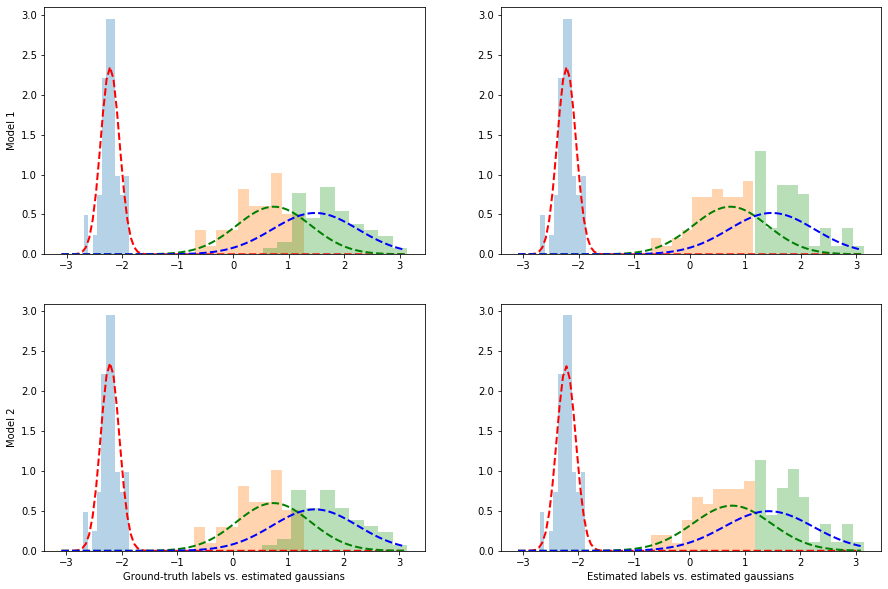

In [13]:
def hard_assignment(data, beta, mu, sigma, mean_beta, iterations):
    res = np.zeros((150,3))
    for i in range(len(data)):
        count = np.zeros(3)
        for j in range(iterations*2):
            # compute y_ij_tild:
            y_ij_tild = beta[j,0] + beta[j,1]*data[i,0] + beta[j,2]*data[i,1] + beta[j,3]*data[i,2] + beta[j,4]*data[i,3]
            p0 = norm(mu[j,0], sigma[j,0]).pdf(y_ij_tild)
            p1 = norm(mu[j,1], sigma[j,1]).pdf(y_ij_tild)
            p2 = norm(mu[j,2], sigma[j,2]).pdf(y_ij_tild)
            lbl = np.argmax([p0,p1,p2])
            count[lbl] = count[lbl] + 1
        
        hard_lbl = np.argmax(count)
        y_i_projected_mean = mean_beta[0] + mean_beta[1]*data[i,0] + mean_beta[2]*data[i,1] + mean_beta[3]*data[i,2] + mean_beta[4]*data[i,3]

        res[i,0] = y_i_projected_mean  # y projected using the mean betas
        res[i,1] = labels[i] # true label
        res[i,2] = hard_lbl # label from hard assignment
    
    return res


iterations = 100

# exract samples of the model's params: beta: (2000, 5), mu: (2000, 3), sigma:(2000, 3)
beta1 = fit_1.extract(['beta'])['beta']
mu1 = fit_1.extract()['mu']
sigma1 = fit_1.extract()['sigma']
mean_beta1 = fit_1.extract(['beta'])['beta'].mean(0)
mean_mu1 = mu1.mean(0)
mean_sigma1 = sigma1.mean(0)

beta2 = fit_2.extract(['beta'])['beta']
mu2 = fit_2.extract()['mu']
sigma2 = fit_2.extract()['sigma']
mean_beta2 = fit_2.extract(['beta'])['beta'].mean(0)
mean_mu2 = mu2.mean(0)
mean_sigma2 = sigma2.mean(0)

# Prepare summary of the samples, estimated (hard) assignment and true labels:
res1 = hard_assignment(data, beta1, mu1, sigma1, mean_beta1, iterations)
res2 = hard_assignment(data, beta2, mu2, sigma2, mean_beta2, iterations)


# Plot the results of the two models:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)


# model 1:
ax[0][0].set_ylabel('Model 1')
ax[0][0].hist(res1[res1[:,1]==0][:,0], alpha=0.33, density=True, label="label (true): "+str(0))
ax[0][0].hist(res1[res1[:,1]==1][:,0], alpha=0.33, density=True, label="label (true): "+str(1))
ax[0][0].hist(res1[res1[:,1]==2][:,0], alpha=0.33, density=True, label="label (true): "+str(2))

ax[0][1].hist(res1[res1[:,2]==0][:,0], alpha=0.33, density=True, label="label (est): "+str(0))
ax[0][1].hist(res1[res1[:,2]==1][:,0], alpha=0.33, density=True, label="label (est): "+str(1))
ax[0][1].hist(res1[res1[:,2]==2][:,0], alpha=0.33, density=True, label="label (est): "+str(2))

ax[0][0].plot(x, norm.pdf(x, loc=mean_mu1[0], scale=mean_sigma1[0]), 'r--', lw=2)
ax[0][0].plot(x, norm.pdf(x, loc=mean_mu1[1], scale=mean_sigma1[1]), 'g--', lw=2)
ax[0][0].plot(x, norm.pdf(x, loc=mean_mu1[2], scale=mean_sigma1[2]), 'b--', lw=2)

ax[0][1].plot(x, norm.pdf(x, loc=mean_mu1[0], scale=mean_sigma1[0]), 'r--', lw=2)
ax[0][1].plot(x, norm.pdf(x, loc=mean_mu1[1], scale=mean_sigma1[1]), 'g--', lw=2)
ax[0][1].plot(x, norm.pdf(x, loc=mean_mu1[2], scale=mean_sigma1[2]), 'b--', lw=2)

# model 2:
ax[1][0].set_ylabel('Model 2')
ax[1][0].hist(res2[res2[:,1]==0][:,0], alpha=0.33, density=True, label="label (true): "+str(0))
ax[1][0].hist(res2[res2[:,1]==1][:,0], alpha=0.33, density=True, label="label (true): "+str(1))
ax[1][0].hist(res2[res2[:,1]==2][:,0], alpha=0.33, density=True, label="label (true): "+str(2))

ax[1][1].hist(res2[res2[:,2]==0][:,0], alpha=0.33, density=True, label="label (est): "+str(0))
ax[1][1].hist(res2[res2[:,2]==1][:,0], alpha=0.33, density=True, label="label (est): "+str(1))
ax[1][1].hist(res2[res2[:,2]==2][:,0], alpha=0.33, density=True, label="label (est): "+str(2))

ax[1][0].plot(x, norm.pdf(x, loc=mean_mu1[0], scale=mean_sigma1[0]), 'r--', lw=2)
ax[1][0].plot(x, norm.pdf(x, loc=mean_mu1[1], scale=mean_sigma1[1]), 'g--', lw=2)
ax[1][0].plot(x, norm.pdf(x, loc=mean_mu1[2], scale=mean_sigma1[2]), 'b--', lw=2)

ax[1][1].plot(x, norm.pdf(x, loc=mean_mu2[0], scale=mean_sigma2[0]), 'r--', lw=2)
ax[1][1].plot(x, norm.pdf(x, loc=mean_mu2[1], scale=mean_sigma2[1]), 'g--', lw=2)
ax[1][1].plot(x, norm.pdf(x, loc=mean_mu2[2], scale=mean_sigma2[2]), 'b--', lw=2)

ax[1][0].set_xlabel('Ground-truth labels vs. estimated gaussians')
ax[1][1].set_xlabel('Estimated labels vs. estimated gaussians')

plt.show()

## Model Checking

**Log probability:**<br>
Here we plot the posterior distribution of the log predictive density log p(y|theta).

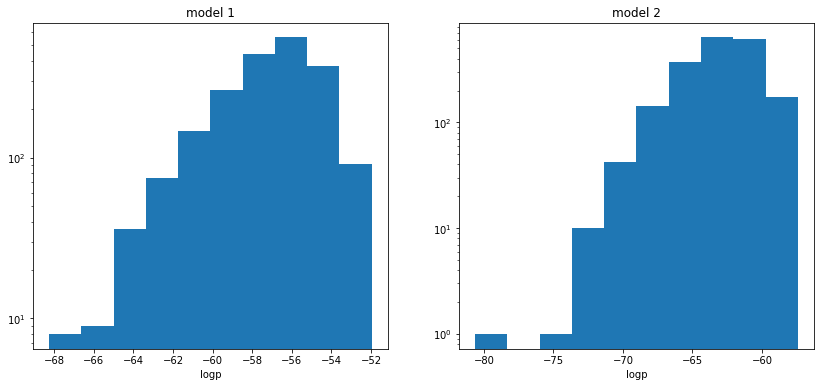

In [14]:
logp_model1 = fit_1.extract()['lp__']
logp_model2 = fit_2.extract()['lp__']

fig, ax = plt.subplots(1,2, figsize=(14, 6))
ax[0].set_xlabel("logp")
ax[1].set_xlabel("logp")

ax[0].set_title("model 1")
ax[0].set_yscale("log")
ax[0].hist(logp_model1)

ax[1].set_title("model 2")
ax[1].set_yscale("log")
ax[1].hist(logp_model2)

plt.show()

### **Generate a replications (y_rep) of the dataset:**<br>
We generate replications of the dataset. Each replication of the data (simulation) is generated in the following way:<br>
Given that the probability for each data point to be associated with each of the Gaussian components is 1/3, we sample 50 data points from each of the Gaussian components separately, ending up with 150 replicated observation set.
For each component z_i, we draw 50 samples of theta_{z_i}. We then sample y_rep given each sampled parameters and get 50 replicated data points.<br>
We perform 3 such simulations.

We also plot the histogram of the real observations by computing $\tilde{y}$ for each real 4-d observation $y$, using the mean values of the sampled $\beta_0, \beta_1, \beta_2, \beta_3, \beta_4$.
      

In [15]:
# Sample one replicated dataset (150 replicated datapoints):
def sample_y_rep(mu, sigma):
    y_rep = np.zeros(150)
    for j in range(150):
        ind = np.random.randint(0, len(mu))
        if j < 50:
            mu_s = mu[ind,0]
            sigma_s = sigma[ind,0]
        elif j < 100:
            mu_s = mu[ind,1]
            sigma_s = sigma[ind,1]
        else:
            mu_s = mu[ind,2]
            sigma_s = sigma[ind,2]
        
        y_rep[j] = np.random.normal(mu_s, sigma_s)
        
    return y_rep

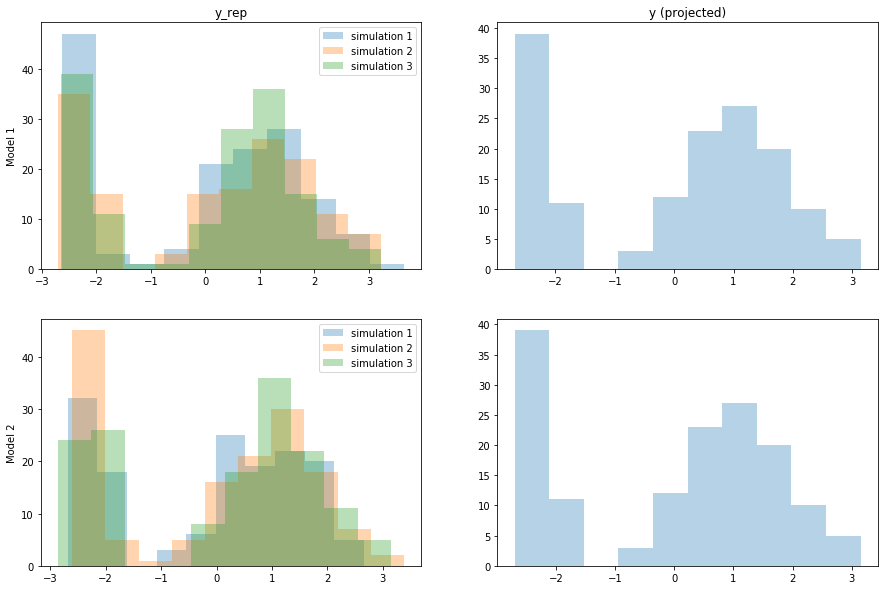

In [16]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

mu1 = fit_1.extract()['mu']  # 2000x3
sigma1 = fit_1.extract()['sigma']  # 2000x3
mean_beta1 = fit_1.extract(['beta'])['beta'].mean(0)

mu2 = fit_2.extract()['mu']  # 2000x3
sigma2 = fit_2.extract()['sigma']  # 2000x3
mean_beta2 = fit_2.extract(['beta'])['beta'].mean(0)

# --- Prepare y_rep:
for i in range(3): # number of simulations of y_rep
    # sample 50 y_rep from each component:
    y_rep1 = sample_y_rep(mu1, sigma1)
    ax[0][0].hist(y_rep1, alpha=0.33, label="simulation "+str(i+1))

for i in range(3): # number of simulations of y_rep
    # sample 50 y_rep from each component:
    y_rep2 = sample_y_rep(mu2, sigma2)
    ax[1][0].hist(y_rep2, alpha=0.33, label="simulation "+str(i+1))
    
# --- Prepare \tilde{y}:
y_tilde1 = np.zeros(150)
for i in range(data.shape[0]):
    y_tilde1[i] = mean_beta1[0] + mean_beta1[1]*data[i,0] + mean_beta1[2]*data[i,1] + mean_beta1[3]*data[i,2] + mean_beta1[4]*data[i,3]

ax[0][1].hist(y_tilde1, alpha=0.33, label="Observations "+str(i+1))
    
y_tilde2 = np.zeros(150)
for i in range(data.shape[0]):
    y_tilde2[i] = mean_beta2[0] + mean_beta2[1]*data[i,0] + mean_beta2[2]*data[i,1] + mean_beta2[3]*data[i,2] + mean_beta2[4]*data[i,3]

ax[1][1].hist(y_tilde2, alpha=0.33, label="Observations "+str(i+1))

ax[0][0].set_title('y_rep')
ax[0][1].set_title('y (projected)')
ax[0][0].set_ylabel('Model 1')
ax[1][0].set_ylabel('Model 2')
ax[0][0].legend()
ax[1][0].legend()
plt.show()

**P-Value:**<br>
Here we compute p-value for the following test statistics: min, max and median values over all observations / replicated observations, per label.<br>
We compute the test statistics for the projected dataset ($\tilde{y}$), per label.<br>
We sample 150 replicated observation set (50 from each component), and compute the test statistics over each set for each of the components in the set.<br>
We then plot the histograms of the min, max and median of the replicated data along with the real observation results (red line), and the p-values for each of the test statistics.

----------MODEL 1:--------------


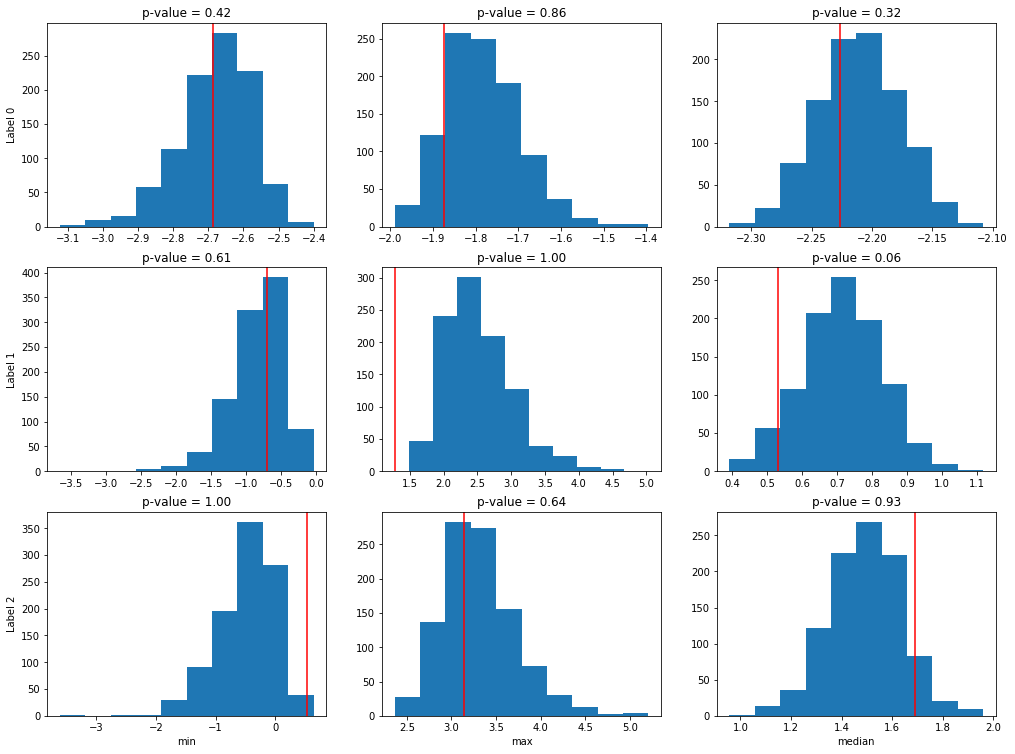

----------MODEL 2:--------------


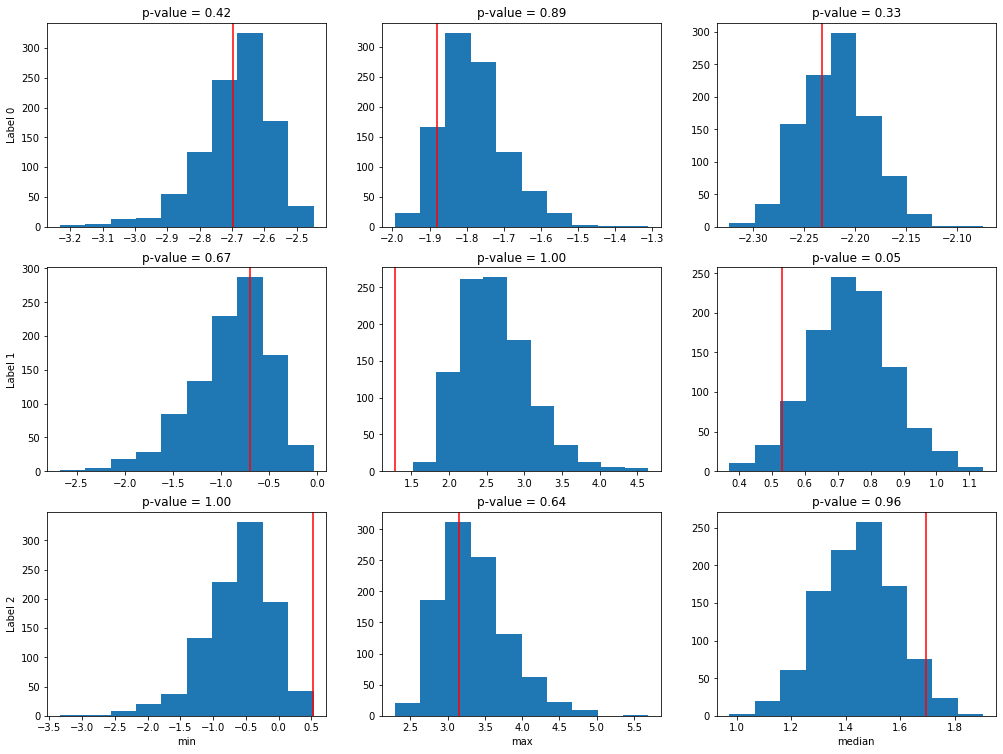

In [17]:
def compute_p_values(model, mu, sigma):
    if model == 'model_1':
        print('----------MODEL 1:--------------')
        # y_tilde with the labels:
        y_tilde_lbl = np.column_stack((y_tilde1, data_and_labels[:,4]))
    else:
        print('----------MODEL 2:--------------')
        # y_tilde with the labels:
        y_tilde_lbl = np.column_stack((y_tilde2, data_and_labels[:,4]))
        
    fig, ax = plt.subplots(3, 3, figsize=(17, 7))
    fig.subplots_adjust(top=1.5)

    S = 1000 # number of samples

    ax[-1][0].set_xlabel("min")
    ax[-1][1].set_xlabel("max")
    ax[-1][2].set_xlabel("median")
    ax[0][0].set_ylabel('Label 0')
    ax[1][0].set_ylabel('Label 1')
    ax[2][0].set_ylabel('Label 2')

    # Test statistics of the observations, per label:
    dataMin = np.zeros(3)
    dataMax = np.zeros(3)
    dataMed = np.zeros(3)
    for i in range(3):
        dataMin[i] = np.min(y_tilde_lbl[y_tilde_lbl[:,1] == float(i)], axis=0)[0]
        dataMax[i] = np.max(y_tilde_lbl[y_tilde_lbl[:,1] == float(i)], axis=0)[0]
        dataMed[i] = np.median(y_tilde_lbl[y_tilde_lbl[:,1] == float(i)], axis=0)[0]


    # Test statistics of the replicated observations, per component:
    rep_min = np.zeros((S,3))
    rep_max = np.zeros((S,3))
    rep_median = np.zeros((S,3))
    for j in range(S):
        y_rep = sample_y_rep(mu, sigma)

        rep_min[j,0] = np.min(y_rep[0:50])
        rep_min[j,1] = np.min(y_rep[50:100])
        rep_min[j,2] = np.min(y_rep[100:150])

        rep_max[j,0] = np.max(y_rep[0:50])
        rep_max[j,1] = np.max(y_rep[50:100])
        rep_max[j,2] = np.max(y_rep[100:150])

        rep_median[j,0] = np.median(y_rep[0:50])
        rep_median[j,1] = np.median(y_rep[50:100])
        rep_median[j,2] = np.median(y_rep[100:150])


    # plot data values of test variables as vertical red lines
    ax[0][0].axvline(dataMin[0], color="red")
    ax[1][0].axvline(dataMin[1], color="red")
    ax[2][0].axvline(dataMin[2], color="red")
    ax[0][1].axvline(dataMax[0], color="red")
    ax[1][1].axvline(dataMax[1], color="red")
    ax[2][1].axvline(dataMax[2], color="red")
    ax[0][2].axvline(dataMed[0], color="red")
    ax[1][2].axvline(dataMed[1], color="red")
    ax[2][2].axvline(dataMed[2], color="red")

    # plot sampled values of test values as histograms
    ax[0][0].hist(rep_min[:,0], zorder=-1)
    ax[1][0].hist(rep_min[:,1], zorder=-1)
    ax[2][0].hist(rep_min[:,2], zorder=-1)
    ax[0][1].hist(rep_max[:,0], zorder=-1)
    ax[1][1].hist(rep_max[:,1],zorder=-1)
    ax[2][1].hist(rep_max[:,2], zorder=-1)
    ax[0][2].hist(rep_median[:,0], zorder=-1)
    ax[1][2].hist(rep_median[:,1], zorder=-1)
    ax[2][2].hist(rep_median[:,2], zorder=-1)

    # compute p-values and display them as subplot titles
    ax[0][0].set_title("p-value = {:.2f}".format(
        len(rep_min[rep_min[:,0] < dataMin[0]]) /
        len(rep_min)))
    ax[1][0].set_title("p-value = {:.2f}".format(
        len(rep_min[rep_min[:,1] < dataMin[1]]) /
        len(rep_min)))
    ax[2][0].set_title("p-value = {:.2f}".format(
        len(rep_min[rep_min[:,2] < dataMin[2]]) /
        len(rep_min)))

    ax[0][1].set_title("p-value = {:.2f}".format(
        len(rep_max[rep_max[:,0] > dataMax[0]]) /
        len(rep_max)))
    ax[1][1].set_title("p-value = {:.2f}".format(
        len(rep_max[rep_max[:,1] > dataMax[1]]) /
        len(rep_max)))
    ax[2][1].set_title("p-value = {:.2f}".format(
        len(rep_max[rep_max[:,2] > dataMax[2]]) /
        len(rep_max)))

    ax[0][2].set_title("p-value = {:.2f}".format(
        len(rep_median[rep_median[:,0] < dataMed[0]]) /
        len(rep_median)))
    ax[1][2].set_title("p-value = {:.2f}".format(
        len(rep_median[rep_median[:,1] < dataMed[1]]) /
        len(rep_median)))
    ax[2][2].set_title("p-value = {:.2f}".format(
        len(rep_median[rep_median[:,2] < dataMed[2]]) /
        len(rep_median)))

    plt.show()


compute_p_values('model_1', mu1, sigma1)
compute_p_values('model_2', mu2, sigma2)

# Model Evaluation

We compare between "model_1" and "model_2" using the WAIC measurement for the evaluation.

**Compute lppd:**

In [18]:
def compute_lppd(model):
    if model == "model_1":
        mu = fit_1.extract()['mu']  # 2000x3
        sigma = fit_1.extract()['sigma']  # 2000x3
        beta = fit_1.extract()['beta'] # 2000x5
    else:
        mu = fit_2.extract()['mu']  # 2000x3
        sigma = fit_2.extract()['sigma']  # 2000x3
        beta = fit_2.extract()['beta']
                            
    lppd = 0
    for i in range(150):  # run on the observations
        tmp_sum = 0
        y = data[i, :]
        for j in range(mu.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            y_tilde = beta[j,0] + beta[j,1]*y[0] + beta[j,2]*y[1] + beta[j,3]*y[2] + beta[j,4]*y[3]
            prob = (1./3)*norm.pdf(y_tilde, mu[j,0], sigma[j,0]) + (1./3)*norm.pdf(y_tilde, mu[j,1], sigma[j,1]) + (1./3)*norm.pdf(y_tilde, mu[j,2], sigma[j,2])
            tmp_sum = tmp_sum + prob

        lppd = lppd + np.log(tmp_sum / mu.shape[0])

    return lppd

lppd_1 = compute_lppd("model_1")
lppd_2 = compute_lppd("model_2")
print("-2*lppd of model_1: ", -2*lppd_1)
print("-2*lppd of model_2: ", -2*lppd_2)

-2*lppd of model_1:  395.72354950408464
-2*lppd of model_2:  397.2507631755997


**Compute p_WAIC_1, p_WAIC_2, and WAIC:**

In [19]:
def compute_p_WAIC_1(model):
    if model == "model_1":
        mu = fit_1.extract()['mu']  # 2000x3
        sigma = fit_1.extract()['sigma']  # 2000x3
        beta = fit_1.extract()['beta'] # 2000x5
    else:
        mu = fit_2.extract()['mu']  # 2000x3
        sigma = fit_2.extract()['sigma']  # 2000x3
        beta = fit_2.extract()['beta']
        
    res = 0
    for i in range(150):  # run on the observations
        tmp_sum_a = 0
        tmp_sum_b = 0
        y = data[i, :]
        for j in range(mu.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            y_tilde = beta[j,0] + beta[j,1]*y[0] + beta[j,2]*y[1] + beta[j,3]*y[2] + beta[j,4]*y[3]
            prob = (1./3)*norm.pdf(y_tilde, mu[j,0], sigma[j,0]) + (1./3)*norm.pdf(y_tilde, mu[j,1], sigma[j,1]) + (1./3)*norm.pdf(y_tilde, mu[j,2], sigma[j,2])
            tmp_sum_a = tmp_sum_a + prob
            tmp_sum_b = tmp_sum_b + np.log(prob)
            
        res = res + np.log(tmp_sum_a / mu.shape[0]) - (tmp_sum_b / mu.shape[0])
    
    return 2*res

p_WAIC_1_m1 = compute_p_WAIC_1("model_1")
p_WAIC_1_m2 = compute_p_WAIC_1("model_2")
print("p_WAIC_1 of model_1: ", p_WAIC_1_m1)
print("p_WAIC_1 of model_2: ", p_WAIC_1_m2)

p_WAIC_1 of model_1:  5.660275469130644
p_WAIC_1 of model_2:  5.45287895501163


In [20]:
def compute_p_WAIC_2(model):
    if model == "model_1":
        mu = fit_1.extract()['mu']  # 2000x3
        sigma = fit_1.extract()['sigma']  # 2000x3
        beta = fit_1.extract()['beta'] # 2000x5
    else:
        mu = fit_2.extract()['mu']  # 2000x3
        sigma = fit_2.extract()['sigma']  # 2000x3
        beta = fit_2.extract()['beta']
              
    avg = []
    for i in range(150):  # run on the observations
        tmp_sum = 0
        tmp_cnt = 0
        y = data[i, :]
        for j in range(mu.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            y_tilde = beta[j,0] + beta[j,1]*y[0] + beta[j,2]*y[1] + beta[j,3]*y[2] + beta[j,4]*y[3]
            prob = (1./3)*norm.pdf(y_tilde, mu[j,0], sigma[j,0]) + (1./3)*norm.pdf(y_tilde, mu[j,1], sigma[j,1]) + (1./3)*norm.pdf(y_tilde, mu[j,2], sigma[j,2])
            tmp_sum = tmp_sum + np.log(prob)
            tmp_cnt = tmp_cnt + 1
            
        avg.append(tmp_sum/tmp_cnt)
    
    res = 0
    for i in range(150):  # run on the observations
        tmp_sum = 0
        y = data[i, :]
        for j in range(mu.shape[0]):  # run on samples:
            # On each theta^s, compute p(y|theta^s):
            y_tilde = beta[j,0] + beta[j,1]*y[0] + beta[j,2]*y[1] + beta[j,3]*y[2] + beta[j,4]*y[3]
            prob = (1./3)*norm.pdf(y_tilde, mu[j,0], sigma[j,0]) + (1./3)*norm.pdf(y_tilde, mu[j,1], sigma[j,1]) + (1./3)*norm.pdf(y_tilde, mu[j,2], sigma[j,2])
            tmp_sum = tmp_sum + ((np.log(prob) - avg[i]) ** 2)
            
        res = res + ((1/(mu.shape[0]-1)) * tmp_sum)
    
    return 2*res

p_WAIC_2_m1 = compute_p_WAIC_2("model_1")
p_WAIC_2_m2 = compute_p_WAIC_2("model_2")
print("p_WAIC_2 of model_1: ", p_WAIC_2_m1)
print("p_WAIC_2 of model_2: ", p_WAIC_2_m2)

p_WAIC_2 of model_1:  11.905543881336085
p_WAIC_2 of model_2:  11.485392026256672


In [21]:
WAIC_1 = -2 * (lppd_1 - p_WAIC_2_m1)
WAIC_2 = -2 * (lppd_2 - p_WAIC_2_m2)
print("WAIC of model_1: ", WAIC_1)
print("WAIC of model_2: ", WAIC_2)

WAIC of model_1:  419.5346372667568
WAIC of model_2:  420.221547228113
